In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from gensim.models import KeyedVectors
import matplotlib
import matplotlib.pyplot as plt

from models import WordEncoder, SentEncoder
from utils import sent_word_tokenize, word_to_index
from config import (
    BATCH_SIZE,
    DEVICE,
    WORD_HIDDEN_SIZE,
    SENT_HIDDEN_SIZE,
    BIDIRECTIONAL,
    Yelp,
    Synthetic,
)

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = [20, 20]

In [2]:
class Attention(nn.Module):
    def __init__(self, input_size):
        super(Attention, self).__init__()
        self.input_size = input_size
        self.fc = nn.Linear(self.input_size, self.input_size)
        self.context_vector = nn.Parameter(torch.randn(self.input_size))
        self.last_weights = []  # for attention visualization

    def forward(self, input):
        output = torch.tanh(self.fc(input))
        output = torch.matmul(output, self.context_vector)
        output = F.softmax(output, dim=1)
        output = output.permute(1, 0)
        input = input.permute(1, 0, 2)
        batch_size = input.shape[1]
        weighted_sum = torch.zeros(batch_size, self.input_size).to(DEVICE)
        self.last_weights.append([])
        for alpha, h in zip(output, input):
            self.last_weights[-1].append(alpha.item())
            alpha = alpha.unsqueeze(1).expand_as(h)
            weighted_sum += alpha * h
        return weighted_sum


class Han(nn.Module):
    "Hierachical Attention Network"

    def __init__(
        self,
        embedding_matrix,
        word_hidden_size,
        sent_hidden_size,
        num_classes,
        batch_size,
    ):
        super(Han, self).__init__()
        self.word_hidden_size = word_hidden_size
        self.word_encoder = WordEncoder(embedding_matrix, word_hidden_size)
        self.word_attention = Attention(word_hidden_size * BIDIRECTIONAL)
        self.sent_hidden_size = sent_hidden_size
        self.sent_encoder = SentEncoder(
            word_hidden_size * BIDIRECTIONAL, sent_hidden_size
        )
        self.sent_attention = Attention(sent_hidden_size * BIDIRECTIONAL)
        self.fc = nn.Linear(sent_hidden_size * BIDIRECTIONAL, num_classes)
        self.init_hidden_state(batch_size)

    def init_hidden_state(self, batch_size):
        self.word_hidden_state = torch.zeros(
            BIDIRECTIONAL, batch_size, self.word_hidden_size
        ).to(DEVICE)
        self.sent_hidden_state = torch.zeros(
            BIDIRECTIONAL, batch_size, self.sent_hidden_size
        ).to(DEVICE)

    def forward(self, input):
        input = input.permute(1, 2, 0)
        self.sent_hidden_state = torch.zeros_like(self.sent_hidden_state).to(DEVICE)
        sent_encoder_outputs = []
        self.word_attention.last_weights = []
        self.sent_attention.last_weights = []
        for sentence in input:
            self.word_hidden_state = torch.zeros_like(self.word_hidden_state).to(DEVICE)
            word_encoder_outputs = []
            for word in sentence:
                word = word.unsqueeze(0)
                output, self.word_hidden_state = self.word_encoder(
                    word, self.word_hidden_state
                )
                word_encoder_outputs.append(output)
            word_attn_input = torch.cat(word_encoder_outputs, dim=0)
            word_attn_input = word_attn_input.permute(1, 0, 2)
            output = self.word_attention(word_attn_input)
            output = output.unsqueeze(0)
            output, self.sent_hidden_state = self.sent_encoder(
                output, self.sent_hidden_state
            )
            sent_encoder_outputs.append(output)
        sent_attn_input = torch.cat(sent_encoder_outputs, dim=0)
        sent_attn_input = sent_attn_input.permute(1, 0, 2)
        output = self.sent_attention(sent_attn_input)
        output = self.fc(output)
        output = F.log_softmax(output, dim=1)
        return output

In [3]:
dataset_config = Synthetic
df = pd.read_csv(dataset_config.TEST_DATASET).fillna("")
wv = KeyedVectors.load(dataset_config.EMBEDDING_FILE)
model = Han(
    embedding_matrix=wv.vectors,
    word_hidden_size=WORD_HIDDEN_SIZE,
    sent_hidden_size=SENT_HIDDEN_SIZE,
    num_classes=len(df.label.unique()),
    batch_size=1,
).to(DEVICE)
model.load_state_dict(
    torch.load(
        "models/synthetic-han-20200429-002451.pth", map_location=torch.device("cpu")
    )
)

<All keys matched successfully>

In [4]:
index = (
    df[(df["label"] == 3) & (df["text"].str.len() > 300) & (df["text"].str.len() < 800)]
    .sample(1)
    .index.tolist()[0]
)
print(f"index = {index}")
label, doc = df.loc[index]
print(f"label = {label}")
print(doc)

tokenized_doc = sent_word_tokenize(doc)
max_words_per_sent = len(max(tokenized_doc, key=len))
features = np.zeros(shape=(1, len(tokenized_doc), max_words_per_sent), dtype=np.int64)
for i, sentence in enumerate(tokenized_doc):
    for j, word in enumerate(tokenized_doc[i]):
        features[0, i, j] = word_to_index(word, wv.vocab)

prediction = model(torch.LongTensor(features).to(DEVICE)).argmax(1).item()
print(f"Predicted label = {prediction}")

index = 76776
label = 3
Haskell is a standardized, general-purpose purely functional programming language, with non-strict semantics and strong static typing. They are written as strings of consecutive alphanumeric characters , the first character being lowercase gentle . He looked inquisitively at his keyboard and wrote another sentence. Erlang is a general-purpose, concurrent, functional programming language. He looked inquisitively at his keyboard and wrote another sentence. Ports are created with the built-in function open_port. Where are my pants?
Predicted label = 3


In [14]:
for index, label, doc in df.itertuples():
    tokenized_doc = sent_word_tokenize(doc)
    max_words_per_sent = len(max(tokenized_doc, key=len))
    features = np.zeros(
        shape=(1, dataset_config.SENT_PER_DOC_80, dataset_config.WORDS_PER_SENT_80),
        dtype=np.int64,
    )
    for i, sentence in zip(range(dataset_config.SENT_PER_DOC_80), tokenized_doc):
        for j, word in zip(range(dataset_config.WORDS_PER_SENT_80), sentence):
            features[0, i, j] = word_to_index(word, wv.vocab)
    print(features)
    break

    prediction = model(torch.LongTensor(features).to(DEVICE)).argmax(1).item()
    if label != prediction:
        print(index)
print(f"index = {index}")
print(f"label = {label}")
print(f"predicted_label = {prediction}")
print(doc)

label = 3
Messages can be sent to and received from ports, but these messages must obey the so-called "port protocol." Initially composing light-hearted and irreverent works, he also wrote serious, sombre and religious pieces beginning in the 1930s. Do you come here often? The arguments can be primitive data types or compound clever data types . Do you have any idea why this is not working?
[[[134  36  54 136  53  11 137 138 139  10 140 141 134 142 143  57 144
   145 146]
  [113 114 115  11 116 117  10  15  87  21 118  10 119  11 120 121 122
   110  57]
  [ 91  92  93  94  95  96   0   0   0   0   0   0   0   0   0   0   0
     0   0]
  [ 57 181  36  54 182  33  34 183 184 229  33  34  14   0   0   0   0
     0   0]
  [ 91  92 218  39 219 220 221  60 222 223  96   0   0   0   0   0   0
     0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0]
  [  0   0   0   0   0   

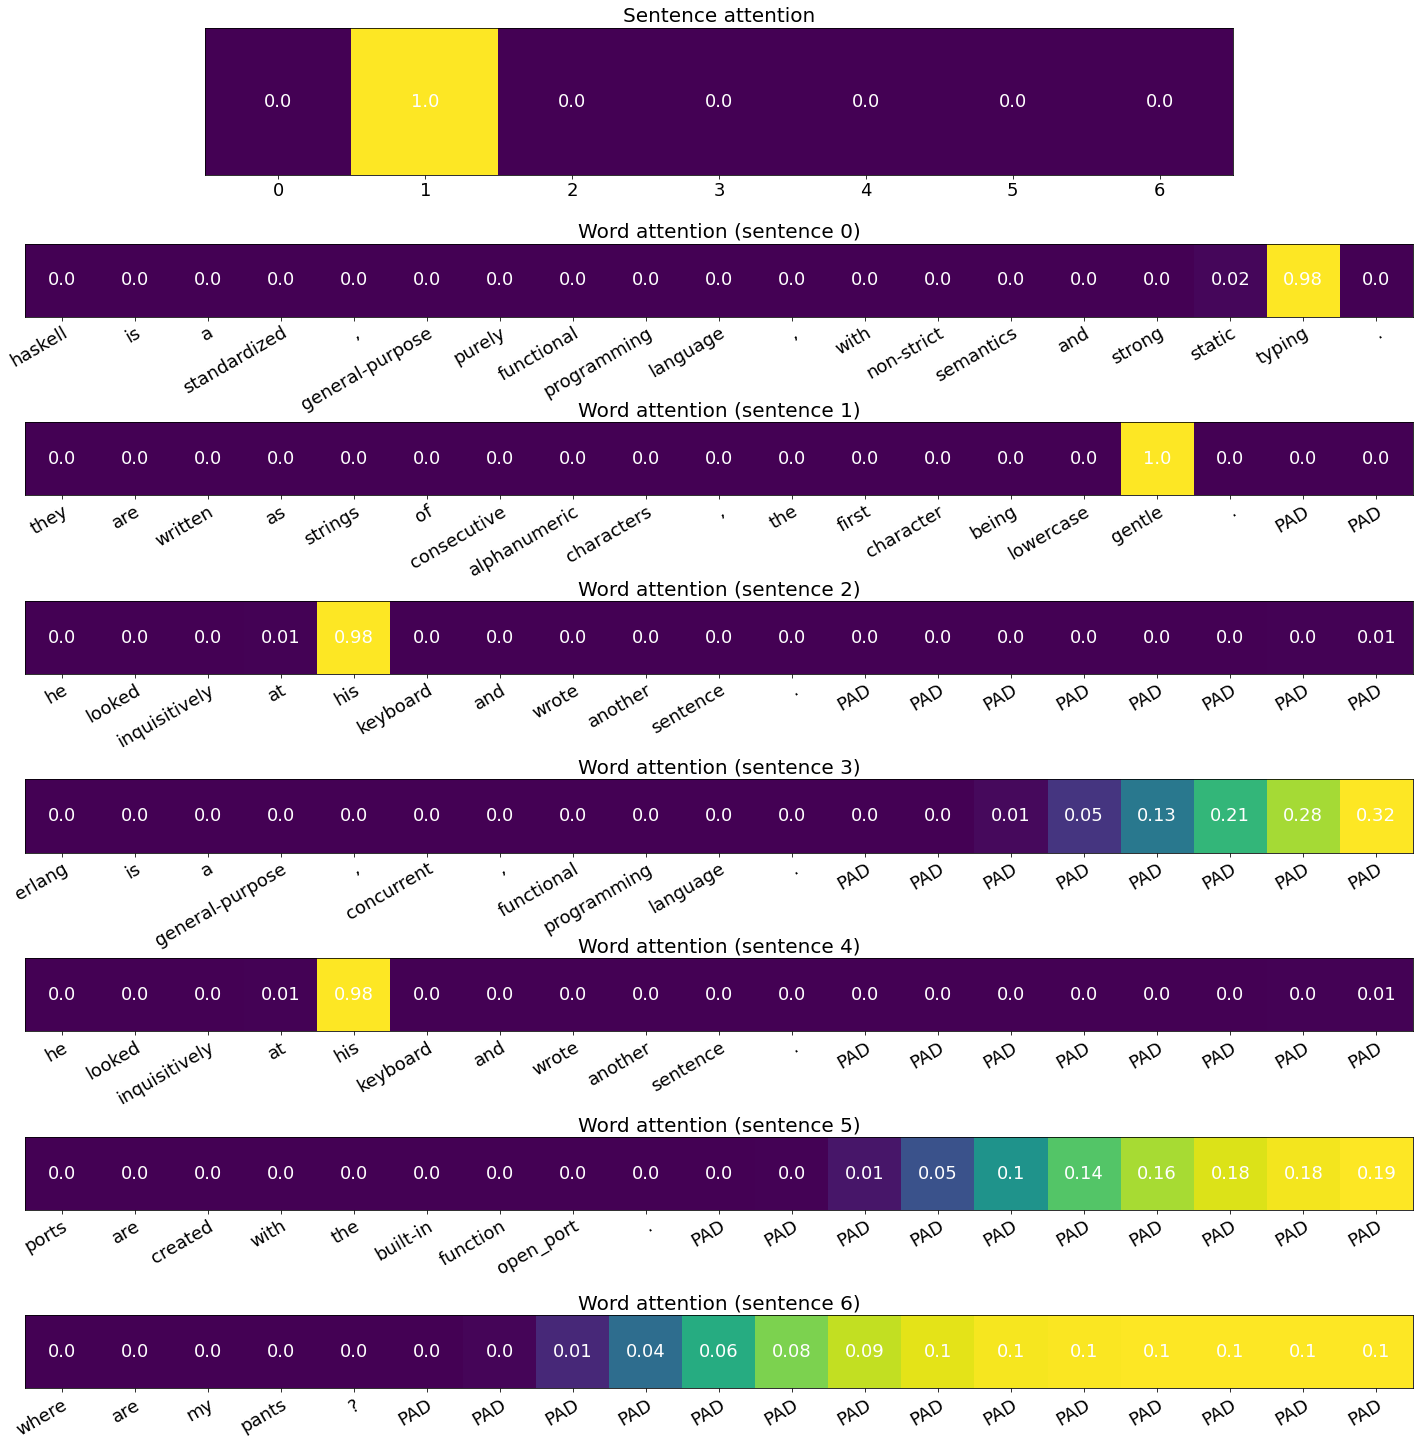

In [5]:
fig, axs = plt.subplots(nrows=(len(tokenized_doc) + 1), ncols=1)
fig.tight_layout()
im = axs[0].imshow([model.sent_attention.last_weights[0]])
axs[0].set_xticks(range(len(tokenized_doc)))
axs[0].set_xticklabels(range(len(tokenized_doc)), fontsize=18)
axs[0].set_title("Sentence attention", fontsize=20)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

# Add attention weight in each rectangle
for j in range(len(tokenized_doc)):
    axs[0].text(
        j,
        0,
        round(model.sent_attention.last_weights[0][j], 2),
        fontsize=18,
        ha="center",
        va="center",
        color="w",
    )

# Remove y ticks
axs[0].yaxis.set_major_locator(plt.NullLocator())

for ax, (i, sentence) in zip(axs[1:], enumerate(features[0])):
    im = ax.imshow([model.word_attention.last_weights[i]])
    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels((wv.index2word[f] for f in sentence), fontsize=18)
    ax.set_title(f"Word attention (sentence {i})", fontsize=20)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    # Add attention weight in each rectangle
    for j in range(len(sentence)):
        ax.text(
            j,
            0,
            round(model.word_attention.last_weights[i][j], 2),
            fontsize=18,
            ha="center",
            va="center",
            color="w",
        )

    # Remove y ticks
    ax.yaxis.set_major_locator(plt.NullLocator())